
#### past
- notebook "2020-06-14.ipynb", tested the capability to continue fitting `clf.fit(X[part], y_enc[part], xgb_model=prev_model)` and saving `clf.save_model(prev_model)` a model in a loop, over parts of a training set. 
- however, the `predict_proba()` step on the test set at each iteration, was taking a very long time. Somtimes half an hour or 40 minutes. 
- In notebook "2020-06-16.ipynb" , I switrched to evaluating on that test set every epoch instead of every batch. Still, this finished `14` epochs in `13` hours and I even cut my data set by `60x` . That also appears to have deteriorated the test accuracy from `acc=0.12` in "2020-06-14.ipynb" to `acc=0.021` in "2020-06-16.ipynb". Again the train and test sets were cut by `60x` so that definitely changed things. But also the `14` epochs did not appear to be helping. 


#### other notes
- feels like better balanced datasets are important . Perhaps otherwise the time to use them is maybe excessively long.
- predict proba is slow ( as per my [2020-06-14 logs here](https://github.com/namoopsoo/learn-citibike/blob/2020-revisit/notes/2020-06-14.md#output-logs) )
- I still feel like `100` iterations feels like a minimum of sorts to aim for.
- got to re-do 3 or 5 fold cross validation now that weird log loss is good.
- If I do the non-sklearn xgboost, I can take advantage of that dataset caching, which I think saved on memory.
- So perhaps one goal is to try that non-sklearn xgboost, w/ `100` iterations, but using at least those parameters from bundle `'/opt/program/artifacts/2020-06-11T041641Z/bundle.joblib'` which appeared to be a good start..

```

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=3,
               min_child_weight=1, missing=nan, n_estimators=100, n_jobs=1,
               nthread=None, objective='multi:softprob', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1),
               
```

#### Are those iterations "built in" ? 
- If I am "manually" iterating then am I actually doing 100*100 = 10,000 iterations?! 
- Perhaps I can check by using the verbose mode

#### Memory consumed by other notebooks
- also important note that I forgot that other notebooks may have been sitting on memory, slowing down the notebook where I was actually running work.

In [27]:
#!ps -p 689 -o pid,ppid,pmem,rss,res
!foo=$(ps -p 689 -o command); echo "$foo"
#!ps -p 689 -o command
# 727
# COMMAND /opt/conda/bin/python -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-11cd26cf-5715-4e84-abd4-ee49b0b06ed9.json

# 689
# COMMAND /opt/conda/bin/python -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-5732db1a-d484-4a58-9d67-de6ef5ac721b.json
#!cat /root/.local/share/jupyter/runtime/kernel-5732db1a-d484-4a58-9d67-de6ef5ac721b.json
#os.getpid()

# 667 , the parent
# COMMAND /opt/conda/bin/python /opt/conda/bin/jupyter-notebook --ip 0.0.0.0 --port 8889 --no-browser --allow-root
#!foo=$(ps auxww); echo "$foo"

COMMAND
/opt/conda/bin/python -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-5732db1a-d484-4a58-9d67-de6ef5ac721b.json


In [7]:
!top

=top - 12:25:39 up 4 days,  6:45,  0 users,  load average: 0.00, 0.02, 0.00
Tasks:  10 total,   1 running,   9 sleeping,   0 stopped,   0 zombie
%Cpu(s):  6.7 us,  0.7 sy,  0.0 ni, 92.3 id,  0.2 wa,  0.0 hi,  0.1 si,  0.0 st
KiB Mem :  2046844 total,    82660 free,  1855176 used,   109008 buff/cache
KiB Swap:  1048572 total,   695520 free,   353052 used.    50424 avail Mem 

  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND     
    1 root      20   0   18236    204    100 S   0.0  0.0   0:00.11 bash        
  667 root      20   0  999296  56116   5060 S   0.0  2.7   0:21.62 jupyter-no+ 
  673 root      20   0  555440   8460   3128 S   0.0  0.4   0:24.88 python      
  689 root      20   0 2521820 1.492g  18052 S   0.0 76.4 760:54.45 python      
  711 root      20   0  555292  44516   6204 S   0.0  2.2   0:15.04 python      
  727 root      20   0  555292  44656   6280 S   0.0  2.2   0:15.52 python      
  743 root      20   0  555292  44644   6316 S   0.0  

In [ ]:
# Let's look how class-balanced the data is... and given some data, "carve" a balanced training set out of it.

In [28]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import datetime; import pytz
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split # (*arrays, **options)
import numpy as np
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from joblib import dump, load
import joblib
import os
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import fresh.utils as fu

from importlib import reload
from collections import Counter
from tqdm.notebook import tqdm
import fresh.preproc.v1 as pv1

In [90]:

model_loc = ('/opt/program/artifacts/2020-06-17T042025Z/model.xg')
#model = joblib.load(model_loc)
model = xgb.XGBClassifier()# .load_model(fname=model_loc)
model.load_model(fname=model_loc)

In [ ]:
# print(X_test_transformed[:2].shape)
# print(X_test_transformed[:2].toarray())
# y_preds = model.predict_proba(X_test_transformed[:2])
# print(y_preds.shape)
# y_preds

#### Quick test of parallel predict_proba 

In [106]:
datadir = '/opt/data'
localdir = '/opt/program'


tripsdf = pd.read_csv(f'{datadir}/2013-07 - Citi Bike trip data.csv'
                     ).sample(frac=0.017, random_state=42)
stationsdf = pd.read_csv(f'{localdir}/datas/stations/stations-2018-12-04-c.csv',
                        index_col=0)


In [107]:

X, y, neighborhoods = fu.prepare_data(tripsdf, stationsdf)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# preproc
(X_transformed,
     one_hot_enc, le,
     y_enc) = pv1.preprocess(X_train, y_train, # X[train_index]
                         neighborhoods)
labels = le.classes_

# Test set
X_test_transformed = one_hot_enc.transform(X_test)
y_test_enc = le.transform(y_test)

In [109]:
xgb_model = xgb.XGBClassifier(objective='multi:softprob'
                             ).fit(X_transformed, 
                                        y_enc, verbose=True)

# 

In [129]:
workdir = fu.make_work_dir(); print(workdir)

/opt/program/artifacts/2020-06-20T181230Z


In [131]:
X_test_transformed.shape

(3585, 78)

In [130]:
joblib.dump({'model': xgb_model, 'note': 'just a quick test'}, f'{workdir}/bundle.joblib')

['/opt/program/artifacts/2020-06-20T181230Z/bundle.joblib']

In [166]:

#X_test_transformed.toarray().shape

(10755, 78)

In [168]:

results = []
for i in tqdm(range(1, 10)):
    X = np.concatenate([X_test_transformed.toarray()]*i)
    start = datetime.datetime.now()
    y_pred_1 = fu.predict_proba(X,
                     model_loc='/opt/program/artifacts/2020-06-20T181230Z/bundle.joblib',
                             parallel=False)
    oneshot_time = fu.do_walltime(start)

    start = datetime.datetime.now()
    y_pred_2 = fu.predict_proba(X,
                     model_loc='/opt/program/artifacts/2020-06-20T181230Z/bundle.joblib',
                             parallel=True)
    parallel_time = fu.do_walltime(start)
    
    results.append({'size': X.shape[0], 'parallel_time': parallel_time,
                   'oneshot_time': oneshot_time})
    # parallel=True
    # 5.77s , 445ms


In [170]:
np.allclose(y_pred_1, y_pred_2)

True

In [175]:
# Ok cool... glad to see I have now added a new tool to my toolbox here, 
# For super small data, parallel overheads outweighs the benefit, but there is a tipping point..
# my goal is for this to also help w/ not just filling and sitting on memory w/o releasing it! 
df = pd.DataFrame.from_records(results)

Text(0, 0.5, 'seconds')

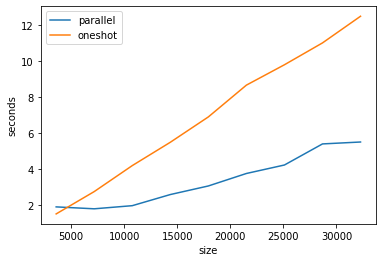

In [179]:
plt.plot(df['size'].tolist(), df.parallel_time.tolist(), label='parallel')
plt.plot(df['size'].tolist(), df.oneshot_time.tolist(), label='oneshot')
plt.legend()
plt.xlabel('size')
plt.ylabel('seconds')

In [180]:
reload(fu)

<module 'fresh.utils' from '/opt/program/fresh/utils.py'>

In [120]:
slices = fu.get_slices(range(200), slice_size=100)
vec = [xgb_model.predict_proba(X_test_transformed[a:b]) for (a,b) in slices]

In [112]:
reload(fu)
print(fu.get_slices(range(1000), slice_size=444))

[[0, 443], [444, 887], [888, 999]]


In [45]:
#help(joblib)
import time
from joblib import Parallel, delayed
from math import sqrt

def mywork(x, y, z=None, a=None):
    time.sleep(5)
    
    return x*y * (z or a)

%time Parallel(n_jobs=5)(delayed(mywork)(i, i+1, z=2) for i in range(10))

CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 10.1 s


[0, 4, 12, 24, 40, 60, 84, 112, 144, 180]

In [78]:
%%time
y_prob_vec = np.random.random(size=(y_test_enc.shape[0],
                       labels.shape[0]))
loss = fu.big_logloss(y_test_enc, y_prob_vec, list(range(len(labels))), parallel=False)
# Wall time: 56.5 s
# Wall time: 906 ms  . huh?


CPU times: user 660 ms, sys: 50 ms, total: 710 ms
Wall time: 725 ms


In [73]:
loss#labels#y_test_enc.shape, y_prob_vec.shape#loss # 4.291267319642341


0.0

In [48]:
y_test_enc.shape, labels.shape

((210854,), (54,))

In [52]:
np.random.random(size=(y_test_enc.shape[0],
                       labels.shape[0]))

array([[0.21080369, 0.43961201, 0.19590716, ..., 0.71289874, 0.33170714,
        0.82601838],
       [0.36605098, 0.13483735, 0.90106828, ..., 0.54691864, 0.4643664 ,
        0.88128189],
       [0.63243054, 0.16359919, 0.66125254, ..., 0.34549834, 0.41448938,
        0.6333276 ],
       ...,
       [0.14012141, 0.33125609, 0.49782631, ..., 0.26443373, 0.86010273,
        0.96617081],
       [0.50237769, 0.86188519, 0.61262241, ..., 0.67107822, 0.36280706,
        0.08816574],
       [0.02359937, 0.74809099, 0.15765813, ..., 0.00790811, 0.13526414,
        0.87367221]])